In [2]:
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from liesel_sparse import band

In [277]:
% % capture
# Import my GP
% run./ GP.ipynb

In [270]:
plt.style.use('bmh')


# /textwidth 472.31595pt.
# \OT1/cmr/m/n/10.95=select font cmr10 at 10.95pt
# \textfont a (a): cmmi10 at 10.95pt
# \scriptfont a (a): cmmi8
# \textfont \alpha (α): cmmi10 at 10.95pt
# \textfont \cap (∩): cmsy10 at 10.95pt
# \textfont = (=): cmr10 at 10.95pt

def set_size(width_pt=472.31595, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** .5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "font.serif": "Computer Modern Roman",
    "text.usetex": True,  # use inline math for ticks
    "text.latex.preamble": r"\usepackage{amsmath}",
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10.95,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    # Cmap
    "image.cmap": "Blues"
})

### Kernel Matrix

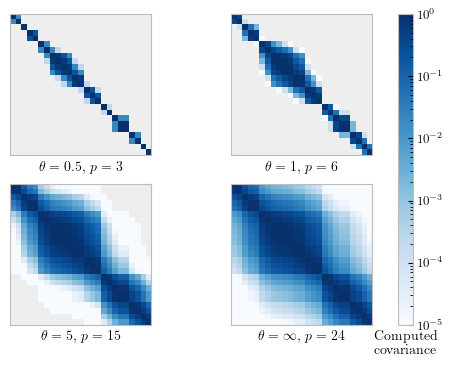

In [345]:
rng = np.random.RandomState(2)
toy_X = jnp.sort(rng.choice(jnp.linspace(0, 10, 100), 25))

fig, axs = plt.subplots(2, 2, figsize=set_size(fraction=1, subplots=(2, 2)))

for i, ax in enumerate(axs.flat):
    thetas = [0.5, 1, 5, float("inf")]
    k = lambda *args: MaternKernel32(1, 0.7, *args) * WendlandTapering(3, thetas[i], *args)
    K = cov_matrix(toy_X, toy_X, k)

    thetas[-1] = r"\infty"
    im = ax.matshow(K, norm=matplotlib.colors.LogNorm(vmin=1e-5, vmax=1))
    ax.set_xlabel(rf"$\theta = {thetas[i]}$, $p = {band.bandwidth(K)}$")
    ax.get_xaxis().set_ticks([]);
    ax.get_yaxis().set_ticks([])

clb = fig.colorbar(im, ax=axs.ravel().tolist(), )
clb.ax.set_xlabel('''Computed
                  covariance''')
#fig.suptitle("Covariance matrices for the Matèrn kernel using different values of $\ell$")
plt.show()
fig.savefig('example_1.pdf', format='pdf')

## Kernel graph

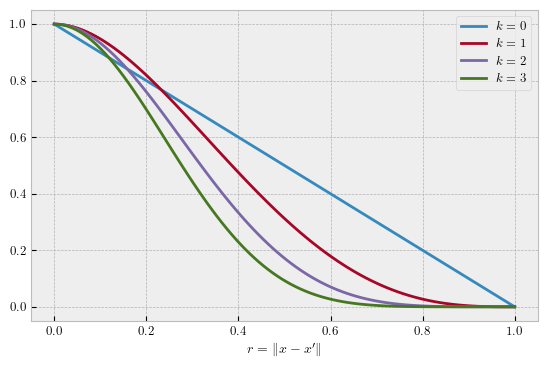

In [338]:
rng = np.random.RandomState(2)
r = jnp.linspace(0, 1, 100)

fig, axs = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))
#plt.subplots_adjust(bottom=-0.1)

for k in [0, 1, 2, 3]:
    y = jax.vmap(lambda y_: WendlandTapering(k, 1, y_, 0))(r)
    im = axs.plot(r, y, label=f"$k = {k}$")
    axs.set_xlabel(r"$\displaystyle r = \lVert x - x' \rVert$")

axs.legend()
plt.show()
fig.savefig('example_2.pdf', format='pdf')

## Draw Functions (prior)

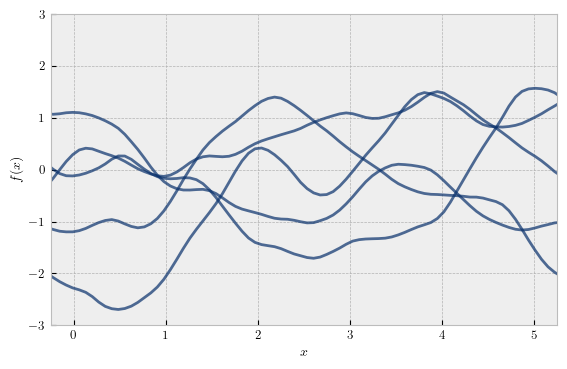

In [340]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

kernel_ = 1.0 * Matern(length_scale=1.0, nu=5/2)
gpr_model = GaussianProcessRegressor(kernel=kernel_)
n_samples = 5

x = np.linspace(-1, 6, 100)
X = x.reshape(-1, 1)

y_samples = gpr_model.sample_y(X, n_samples, random_state=5)

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))

for idx, single_prior in enumerate(y_samples.T):
    ax.plot(x, single_prior, alpha=0.7, lw = 2, c = matplotlib.cm.get_cmap("Blues")(1.0))

ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.set_xlim([-0.25, 5.25])
ax.set_ylim([-3, 3])

plt.show()
fig.savefig('example_3.pdf', format='pdf')

## Contour

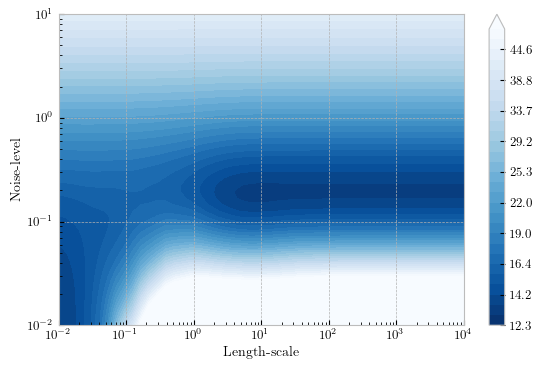

In [420]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))

##--
def target_generator(X, add_noise=False):
    target = 1/4 * np.cos(2 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.4, size=target.shape)
    return target.squeeze()

#---
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 5, size=20).reshape(-1, 1)
y_train = target_generator(X_train, add_noise=True)
#----
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gpr.fit(X_train, y_train)
#---

length_scale = np.logspace(-2, 4, num=50)
noise_level = np.logspace(-2, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=30), decimals=1)
im = ax.contourf(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels = level - 1,
    norm = LogNorm(),
    cmap = "Blues_r",
    extend = "max",
)

plt.colorbar(im, extend='max')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")

plt.show()
fig.savefig('example_4.pdf', format='pdf')